Limpandoo mais stopwords

In [66]:
import pandas as pd
import numpy as np
import os as os
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import acessos as ac
from arabica import arabica_freq
from unidecode import unidecode
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [67]:
query = """

select 
msg.id_issue
, msg.dt_envio_mensagem
, nm_entidade
, msg.ds_message
, novas_tags.hierarquia_4
, novas_tags.fila_de_atendimento
from cx_curated_zone.helpshift_issues_messages msg
left join "cx_curated_zone"."helpshift_issues" AS issues_macro ON msg."id_issue" = issues_macro."id_issue"
left join "cx_curated_zone"."helpshift_tag_niveis" AS helpshift_tag ON msg."id_issue" = helpshift_tag."id_issue"
left join processed_zone_api_cxm_tags.tags_hierarquia_gerencial as novas_tags ON trim(lower(n3)) = trim(lower(nm_tag_n3))
where ds_entidade = 'bot'
and dt_envio_mensagem >= to_date('2022-06-01','yyyy-mm-dd')
order by rand() desc
limit 50000

"""



df = ac.df_athena('flavia-costa', query)

In [68]:
def replace_unuseful_messages(text):
    '''
    Replace automatic and irrelevant (for the project purpose) messages with empty string
    '''
    unuseful_messages = [
        'Outros assuntos',
        'Quero falar de outra coisa',
        'Quero resolver uma coisa',
        'Falar com atendente',
        '&Eacute; outra coisa',
        '&Eacute; outro assunto',
        'Voltar pro come&ccedil;o',
        '&Eacute; outro motivo',
        'Quero falar com atendente',
        'Me mostra as op&ccedil;&otilde;es de antes',
        'Quero falar de outro assunto',
        '&Eacute; outro assunto',
        '&Eacute; outra coisa ',
        'N&atilde;o, ainda tenho d&uacute;vidas',
        'Nenhuma das op&ccedil;&otilde;es',
        'Falar de outra coisa',
        'Quero voltar pro come&ccedil;o',
        'Voltar pro come&ccedil;o',
        'Falar com atendente',
        'Pode sim Por favor',
        'Não, ainda tenho dúvidas',
        'Certo',
        'Obrigado',
        'Responde'
    ]

    if text.strip() in unuseful_messages:
        return ''

    return text

In [69]:
def remove_emoji(text):
    '''
    Replace emojis with empty string
    '''
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', str(text))

In [70]:
def clean_text(x):
    x = x.strip()
    x = x.lower()
    x = unidecode(x)
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x

In [71]:
def retira_saudacoes(text):
       
   regex_list = [
        'bo[ma] (dia|tarde|noite)',
        'agradeco', 'agradecido',
        '(tu?do?|esta|tah?) (b[eo]m|cert(inh)?[oa]|ok)',
        'ok', 'okay', 'sim',
        'oi{1,}e{0,}', 'ola', 'opa',
        'beleza', 'blz',
        'compreendi(do)?',
        'entendi(do)?',
        'tendi(do)?',
        '(muito|mt)? ?(obrigad[oa]|obg|b[oe]m)',
        'b?a{1,10}h?',
        'abracos?',
        '(por|de) na?da?',
        'por (favor|gentileza)'
    ]
   
   regex_list += stopwords
   pattern = r'\b(' + '|'.join(regex_list) + r')\b'
   text = re.sub(pattern, '', str(text))
   text = text.replace('  ',' ')
   return text

In [72]:
stopwords= ['não','nao',  'da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce', 'cartao', 'limite',
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um',
            'fatura', 'faturas', 'ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro', 'isso']

In [73]:
df['ds_message_tratada'] = df['ds_message'].apply(replace_unuseful_messages)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(remove_emoji)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(retira_saudacoes)

## substituindo endereços pela palavra 'endereço'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("rua"), 'endereço', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("cep"), 'endereço', df['ds_message_tratada'])

## substituindo links pela palavra 'url'
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("https"), 'url', df['ds_message_tratada'])

## Substituido todos os códigos pela palavra 'código' - os código encontrados continham wi5, wi9, wi8, yf ou bc
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi5"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi9"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("wi8"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("bc"), 'código', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("yf"), 'código', df['ds_message_tratada'])
##Tratando algumas palavras
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('ª', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace('º', '')
df['ds_message_tratada'] = df['ds_message_tratada'].str.replace(' r ', ' ')

## protocolo / ate dias / voce pode 
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("protocolo"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("ate dias"), '', df['ds_message_tratada'])
df['ds_message_tratada'] = np.where(df['ds_message_tratada'].str.contains("voce pode"), '', df['ds_message_tratada'])

df_clean = df.query('ds_message_tratada != " "').query('ds_message_tratada != "  "').query('ds_message_tratada != ""').query('ds_message_tratada != "   "')

In [74]:
df_clean.head()

,id_issue,dt_envio_mensagem,nm_entidade,ds_message,hierarquia_4,fila_de_atendimento,ds_message_tratada
0,12737090,2022-11-19 14:57:49,bot pag - Logística - Segunda via - Reconhecim...,Qual o motivo da solicitação de segunda via?,Dúvidas PIX,Fraude,qual motivo solicitacao segunda via
1,11811049,2022-09-30 17:47:20,bot will - menu inicial (5),Certo. Aqui estão os assuntos mais procurados....,None,None,certo estao assuntos procurados escolhe deles
2,12981387,2022-12-01 18:28:47,bot will - gamificação novo,Que legal! Você tá participando da nossa campa...,None,None,legal participando nossa campanha aumento
3,10932781,2022-08-13 19:59:10,bot will - menu inicial (5),Tamb&eacute;m tenho essas op&ccedil;&otilde;es...,Validação novo dispositivo,Fraude,tambem tenho essas opcoes
5,10645791,2022-07-28 15:23:03,bot will - menu inicial (5),Tamb&eacute;m tenho essas op&ccedil;&otilde;es...,Chat duplicado,Geral,tambem tenho essas opcoes


In [75]:
#!pip install gensim

In [76]:
from tqdm import tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk.data
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/flavia.costa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [77]:
w2v_total_data = list(df_clean['ds_message_tratada'].unique())

In [78]:
def build_model(max_epochs, vec_size, alpha, text):
    
    train_text = [TaggedDocument(words=str(s).lower().split(), tags=[i]) for i, s in enumerate(text)]

    model = Doc2Vec(vector_size = vec_size,
                 hs = 1 #hierarquical softmax
               , dm = 0
               , dm_concat = 0
               , dbow_words = 1
               , window = 10
               , alpha= alpha
               , min_alpha= 0.00025
               , min_count= 1
               )
    
    model.build_vocab(train_text)
    
    # With the model built we simply train on the data.
    
    for epoch in range(max_epochs):
        print(f"Iteration {epoch}")
        model.train(train_text,
                   total_examples=model.corpus_count,
                   epochs=model.epochs)

     # Now simply save the model to avoid training again. 
    
    #model.save("Event2Mind_Intentions.model")
    #print("Model Saved")
    return model

In [79]:

model = build_model(max_epochs=250, vec_size=400, alpha=0.03, text = w2v_total_data)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [80]:
vetorDoc = model.wv.vectors

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) #Explicar 95% da variância
pca.fit(vetorDoc)
vetorDoc_pca = pca.transform(vetorDoc)

componentes = vetorDoc_pca.shape[1]
print(componentes)

180


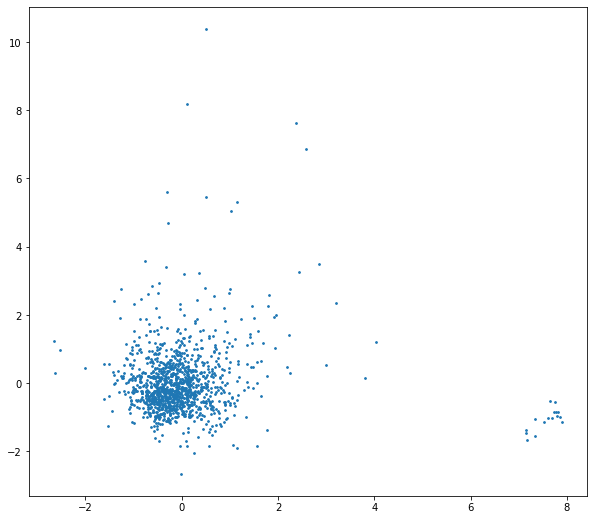

In [82]:
cluster_embedding = vetorDoc_pca

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')
     

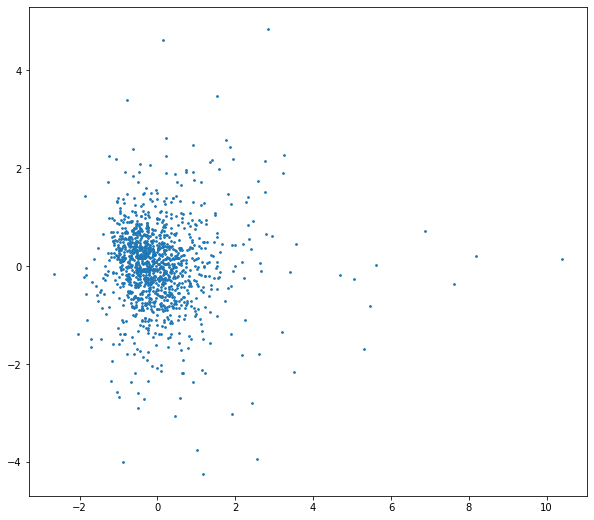

In [83]:
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 1], cluster_embedding[:, 3], s=3, cmap='Spectral')

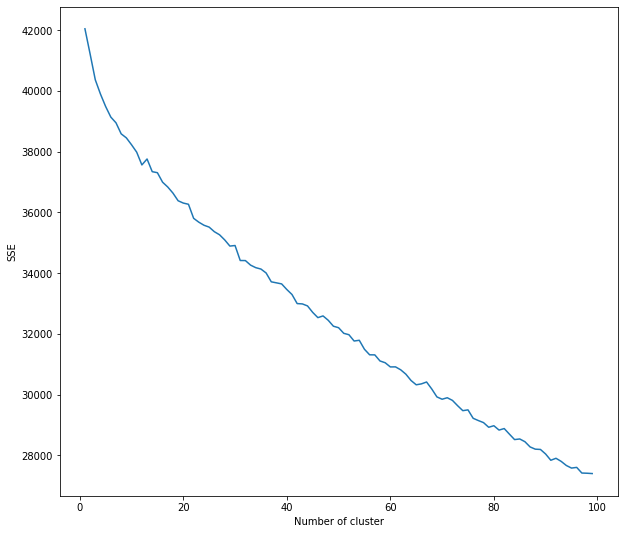

In [84]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, max_iter=500).fit(cluster_embedding)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [85]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30).fit(cluster_embedding)
cluster = kmeans.predict(cluster_embedding)

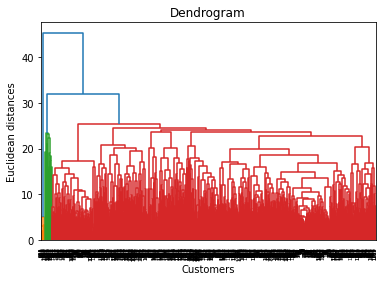

In [99]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(cluster_embedding, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [100]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 20, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(cluster_embedding)
y_hc

array([2, 2, 2, ..., 8, 8, 9])

In [101]:
df_cluster = pd.DataFrame(list(zip(cluster, w2v_total_data, y_hc)), 
               columns =['cluster', 'vocabulo', 'cluster_hie'])
df_cluster.head()

,cluster,vocabulo,cluster_hie
0,28,qual motivo solicitacao segunda via,2
1,28,certo estao assuntos procurados escolhe deles,2
2,28,legal participando nossa campanha aumento,2
3,28,tambem tenho essas opcoes,2
4,28,prefere agora,2


In [87]:
df_cluster['cluster'].value_counts()

28    430
11     98
2      56
1      16
16     11
15      8
20      8
4       7
9       7
8       6
18      6
22      6
13      5
19      3
12      2
6       2
23      1
29      1
10      1
Name: cluster, dtype: int64

In [102]:
df_cluster['cluster_hie'].value_counts()

2     275
9     116
19     65
6      49
5      29
0      26
3      23
13     21
8      19
16     19
7      19
10      9
14      3
4       1
Name: cluster_hie, dtype: int64

In [103]:
df_cluster['dt_envio_mensagem'] = pd.to_datetime("2022-01-12")

In [104]:
def ranking_cluster(df_clean, cluster):
    
    df_agg_ungroup_final = pd.DataFrame([], columns=['unigram', 'unigram_freq',
                                                     'bigram','bigram_freq','trigram','trigram_freq', 'cluster'])
    
    for i in df_clean[cluster].unique():
        try:
            df_clean_tmp = df_clean[df_clean[cluster] == i ]
            df_agg_ungroup_tmp = arabica_freq(
                text = df_clean_tmp['vocabulo'],
                time = df_clean_tmp['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 10,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True) 
            
            result_temp = pd.DataFrame({'unigram': df_agg_ungroup_tmp['unigram'], 'unigram_freq': df_agg_ungroup_tmp['unigram_freq'],
                                        'bigram': df_agg_ungroup_tmp['bigram'], 'bigram_freq': df_agg_ungroup_tmp['bigram_freq'],
                                        'trigram': df_agg_ungroup_tmp['trigram'], 'trigram_freq': df_agg_ungroup_tmp['trigram_freq']}, index=[0])
            
            result_temp['cluster'] = i
                    
            df_agg_ungroup_final = df_agg_ungroup_final.append(result_temp)

        except IndexError:
            pass
                
    return df_agg_ungroup_final

In [105]:
df_resumo = ranking_cluster(df_cluster, 'cluster')
df_resumo['unigram_freq'] = df_resumo['unigram_freq'].astype('int')
df_resumo['bigram_freq'] = df_resumo['bigram_freq'].astype('int')
df_resumo['trigram_freq'] = df_resumo['trigram_freq'].astype('int')
df_resumo['cluster'] = df_resumo['cluster'].astype('str')

df_resumo['unigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['unigram']
df_resumo['bigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['bigram']
df_resumo['trigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['trigram']

In [106]:
df_resumo.head(30)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq,cluster,unigram_h,bigram_h,trigram_h
0,pode,51,"acesse,menu",17,"gerar,boleto,app",12,28,28 : pode,"28 : acesse,menu","28 : gerar,boleto,app"
0,pode,12,"tela,inicial",4,"ate,meia,hora",3,11,11 : pode,"11 : tela,inicial","11 : ate,meia,hora"
0,conta,10,"gerar,boleto",5,"fechadas,podem,indisponiveis",2,2,2 : conta,"2 : gerar,boleto","2 : fechadas,podem,indisponiveis"
0,ja,2,"voltou,will",1,"voltou,will,ja",1,9,9 : ja,"9 : voltou,will","9 : voltou,will,ja"
0,conta,3,"tela,inicial",3,"volta,tela,inicial",2,16,16 : conta,"16 : tela,inicial","16 : volta,tela,inicial"
0,tirar,1,"tirar,selfie",1,"tirar,selfie,habilitar",1,12,12 : tirar,"12 : tirar,selfie","12 : tirar,selfie,habilitar"
0,r,4,"r,ordm",3,"ordm,fase,r",3,4,4 : r,"4 : r,ordm","4 : ordm,fase,r"
0,will,2,"vamos,descobrir",1,"vamos,descobrir,rolando",1,8,8 : will,"8 : vamos,descobrir","8 : vamos,descobrir,rolando"
0,encontra,1,"encontra,devolucao",1,"encontra,devolucao,parte",1,19,19 : encontra,"19 : encontra,devolucao","19 : encontra,devolucao,parte"
0,pode,4,"pode,usar",2,"pode,usar,virtual",2,1,1 : pode,"1 : pode,usar","1 : pode,usar,virtual"


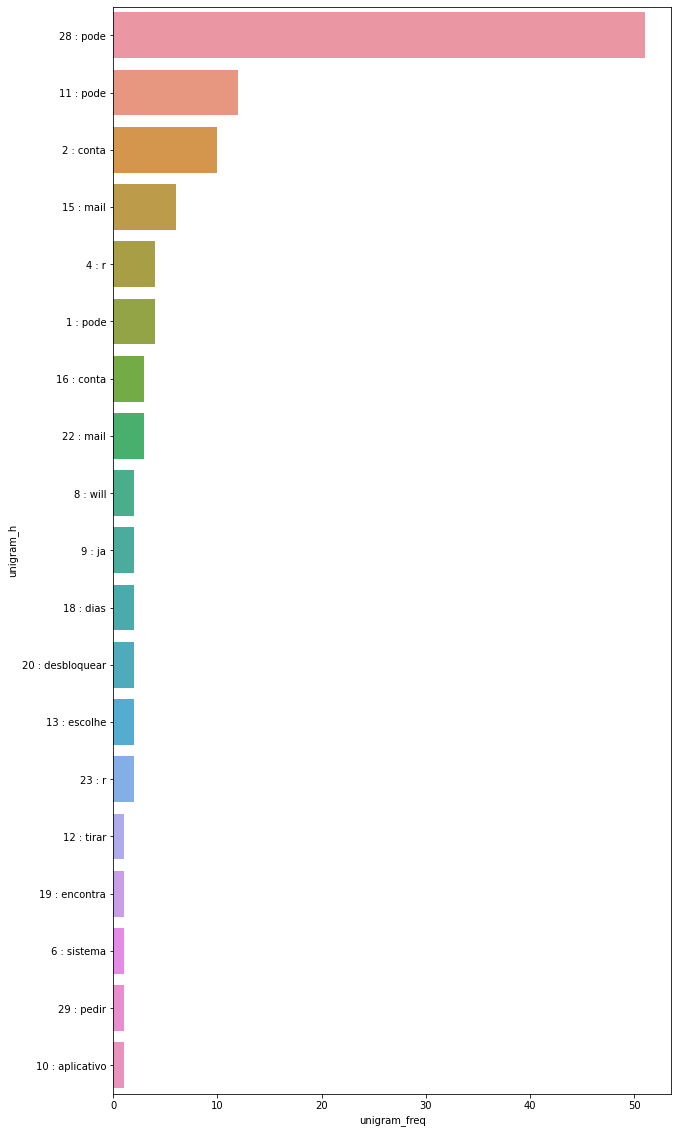

In [92]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='unigram_freq', ascending=False), x = 'unigram_freq', y = 'unigram_h')
plt.show()

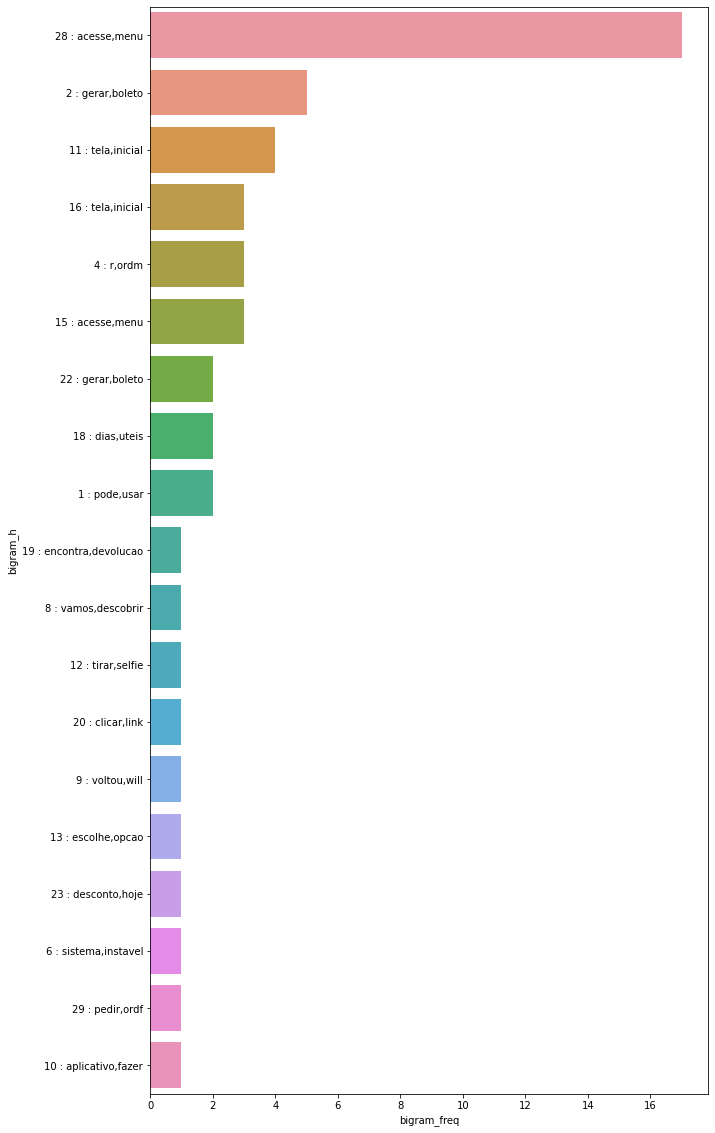

In [93]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='bigram_freq', ascending=False), x = 'bigram_freq', y = 'bigram_h')
plt.show()

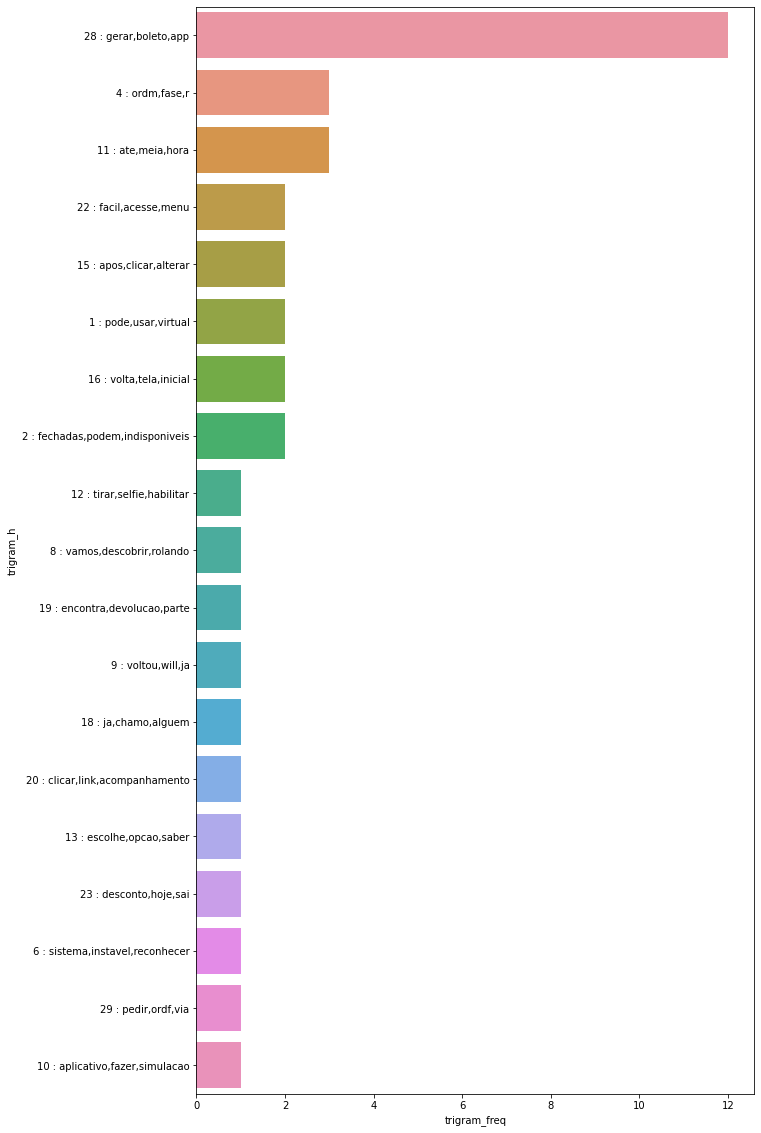

In [94]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

In [107]:
df_resumo = ranking_cluster(df_cluster, 'cluster_hie')
df_resumo['unigram_freq'] = df_resumo['unigram_freq'].astype('int')
df_resumo['bigram_freq'] = df_resumo['bigram_freq'].astype('int')
df_resumo['trigram_freq'] = df_resumo['trigram_freq'].astype('int')
df_resumo['cluster'] = df_resumo['cluster'].astype('str')

df_resumo['unigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['unigram']
df_resumo['bigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['bigram']
df_resumo['trigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['trigram']

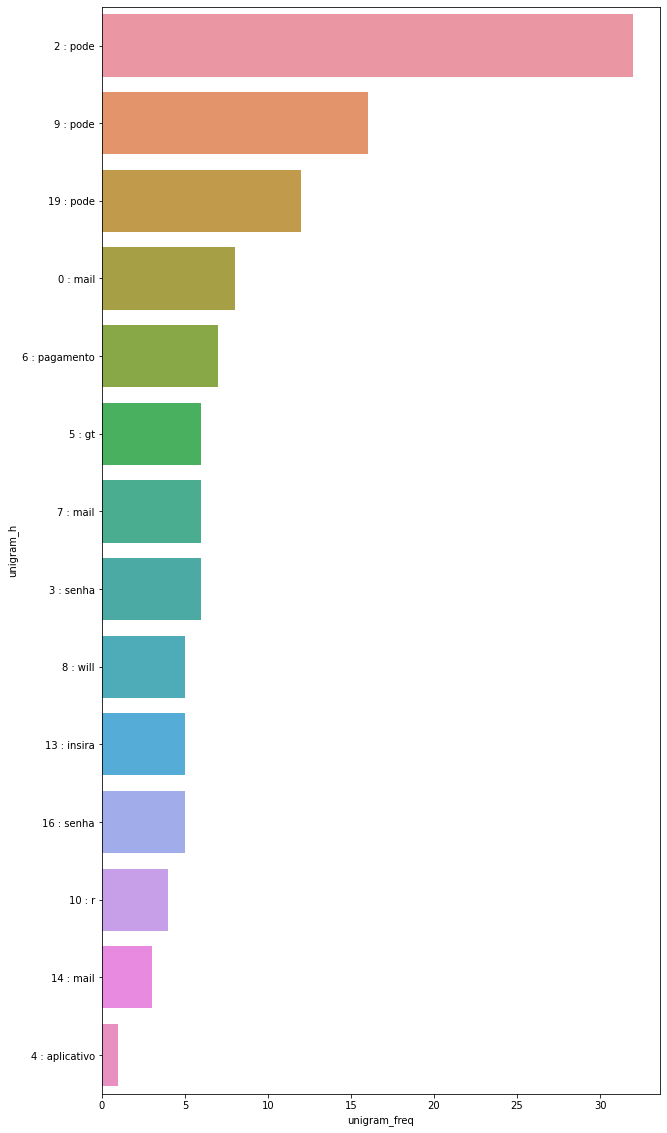

In [108]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='unigram_freq', ascending=False), x = 'unigram_freq', y = 'unigram_h')
plt.show()

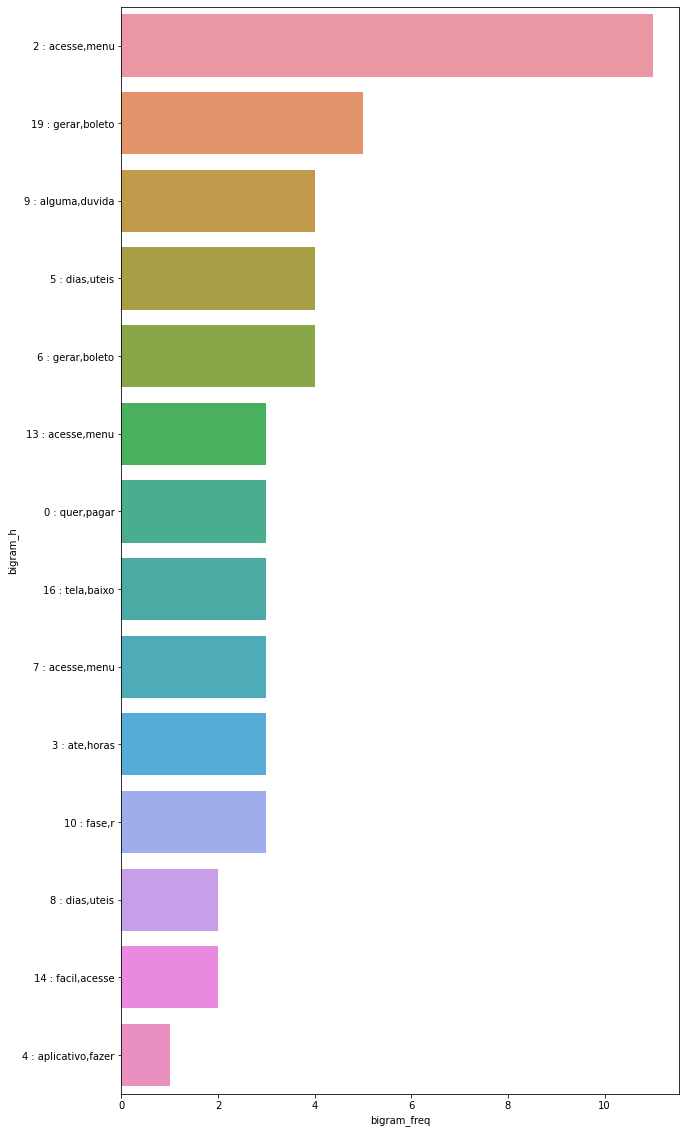

In [110]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='bigram_freq', ascending=False), x = 'bigram_freq', y = 'bigram_h')
plt.show()

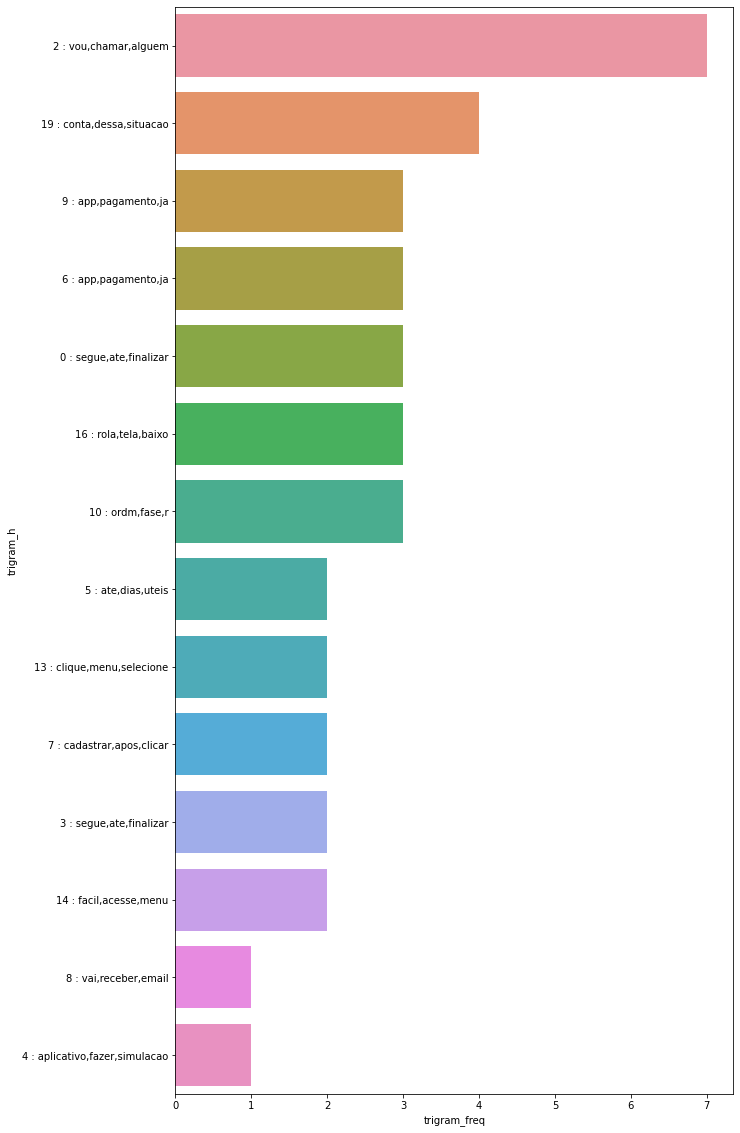

In [111]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

/tmp/ipykernel_108528/4228255973.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


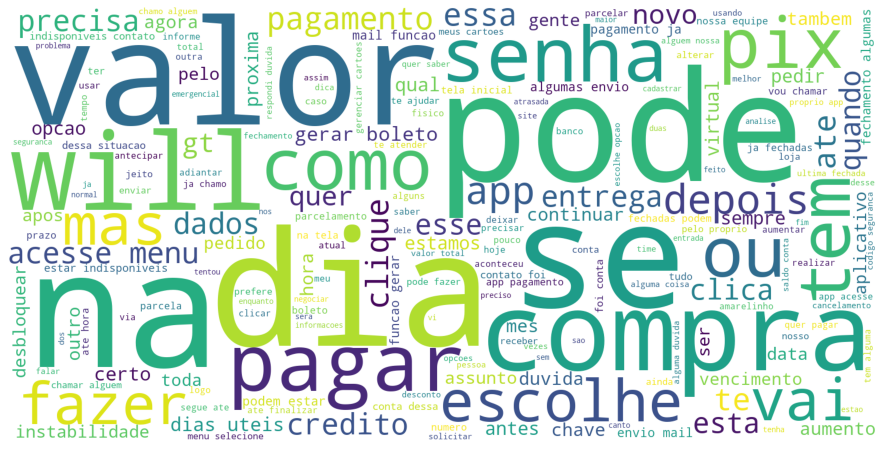

In [96]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

cl_tmp = df_cluster.query('cluster == 28')[df_cluster['vocabulo'].notnull()]['vocabulo']
all_other = " ".join(s for s in cl_tmp)
stopwords_v = set(STOPWORDS)
stopwords_v.update(stopwords)
wordcloud = WordCloud(stopwords=stopwords_v,
                      max_font_size = 300,
                      background_color='white', width=1600,                            
                      height=800).generate(all_other)

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

In [ ]:
model.wv.similar_by_word("cartao")

[('virtual', 0.29170936346054077),
 ('desbloquear', 0.2644064426422119),
 ('chegar', 0.2635643780231476),
 ('segunda', 0.2367205172777176),
 ('senha', 0.22228142619132996),
 ('meus', 0.22071728110313416),
 ('gerenciar', 0.2206675261259079),
 ('via', 0.2189355492591858),
 ('fisico', 0.2161983847618103),
 ('cartoes"', 0.21285118162631989)]

In [97]:
df_agg_ungroup_tmp = arabica_freq(
                text = df_clean['ds_message_tratada'],
                time = df_clean['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 30,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True) 

In [98]:
df_agg_ungroup_tmp.head(40)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq
0,escolhe,7067,"certo,estao",4317,"certo,estao,assuntos",4317
1,certo,6532,"estao,assuntos",4317,"estao,assuntos,procurados",4317
2,assuntos,6209,"assuntos,procurados",4317,"assuntos,procurados,escolhe",4317
3,ja,5930,"procurados,escolhe",4317,"usufruir,beneficios,pag",1847
4,estao,4388,"ja,chamo",3247,"saber,detalhes,dessa",1847
5,procurados,4317,"duvida,assunto",2395,"pagamento,principalmente,continuar",1847
6,duvida,4296,"tambem,opcoes",1936,"principalmente,continuar,oportunidade",1847
7,will,4036,"pessoa,equipe",1861,"continuar,oportunidade,usufruir",1847
8,opcoes,3798,"usufruir,beneficios",1847,"oportunidade,usufruir,beneficios",1847
9,pag,3703,"novidade,pag",1847,"dessa,novidade,acesse",1847
